# Annual ASHP Energy-Exergy Analysis Figures

This notebook contains all the figures used in the paper analyzing the annual performance of an Air Source Heat Pump (ASHP) system from both energy and exergy perspectives.

## Overview

This notebook is organized into sections, each corresponding to a figure in the paper:
- **Figure 3**: Environmental temperature and loads
- **Figure 6**: COP contour maps for cooling and heating modes
- **Figure 7**: Fan characteristics (indoor and outdoor units)
- **Figure 9**: Energy efficiency (COP) grid analysis
- **Figure 10**: Exergy efficiency grid analysis
- **Figure 11**: Carnot efficiency grid analysis
- **Figure 12**: Exergy rate per unit air flow
- **Figure 13**: January and August hourly analysis
- **Figure 14**: April and October hourly analysis
- **Figure 15**: Monthly aggregated analysis
- **Figure A1**: Internal heat gains schedule

Each section can be run independently and includes detailed comments explaining the analysis methodology.


## Initial Setup

This section imports all necessary libraries and sets up the plotting style for consistent figure formatting throughout the notebook.


In [3]:
# Import required libraries
import sys
sys.path.append('src')
import enex_analysis as enex
import matplotlib.pyplot as plt
import dartwork_mpl as dm
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")


Load colors...
Load colormaps...
Libraries imported successfully.


## Plot Style Configuration

This section configures font sizes, padding, and other plotting style parameters for consistent figure formatting throughout the notebook.


In [4]:
# ===============================
# Plot Style Settings
# ===============================
# Configure font sizes and padding for consistent figure formatting

# Set default font size
plt.rcParams['font.size'] = 9

# Font size dictionary for different text elements
# Uses dartwork_mpl font size function with relative scaling
fs = {
    'label': dm.fs(0),          # Main axis labels
    'tick': dm.fs(-1.0),        # Tick labels
    'legend': dm.fs(-1.5),      # Legend text
    'subtitle': dm.fs(-0.5),   # Subtitle/panel labels
    'cbar_tick': dm.fs(-1.5),  # Colorbar tick labels
    'cbar_label': dm.fs(-1.5), # Colorbar axis label
    'cbar_title': dm.fs(-1),   # Colorbar title
    'setpoint': dm.fs(-1),      # Setpoint annotation text
    'text': dm.fs(-2.0),       # General text annotations
}

# Padding dictionary for spacing adjustments
pad = {
    'label': 6,  # Axis label padding
    'tick': 5,   # Tick label padding
}

# Line width array for various plot elements
LW = np.arange(0.25, 3.0, 0.25)

# Apply the dartwork_mpl plotting style
dm.use_style()

print("Plot style configured successfully.")


Plot style configured successfully.


## Data Loading and Preprocessing

This section loads the hourly office data from `small_office_hour.csv` and performs necessary preprocessing steps:
- Clean Date/Time column (remove extra whitespace)
- Calculate day of week (assuming January 1st is Sunday)
- Zero out weekend loads (Saturday and Sunday)
- Separate heating and cooling seasons (heating: Oct-Mar, cooling: Apr-Sep)


In [9]:
# Load the raw hourly office data
# Find the repository root directory (contains 'data' folder)
repo_root = Path.cwd()
for parent in [repo_root] + list(repo_root.parents):
    if (parent / 'data').exists() or (parent / 'pyproject.toml').exists() or (parent / '.git').exists():
        repo_root = parent
        break

# Load the CSV file
data_file = repo_root / 'data' / 'small_office_hour.csv'
weekday_df = pd.read_csv(data_file)

# Find column names (they may have trailing spaces)
cols = list(weekday_df.columns)
date_col = None
heating_col = None
cooling_col = None

# Find Date/Time column
for c in cols:
    if c.strip() == 'Date/Time' or 'Date/Time' in c:
        date_col = c
        break

# Find heating column
for c in cols:
    if 'DistrictHeatingWater:Facility' in c:
        heating_col = c
        break

# Find cooling column
for c in cols:
    if 'DistrictCooling:Facility' in c:
        cooling_col = c
        break

# Create cleaned Date/Time column (remove extra whitespace)
weekday_df['Date/Time_clean'] = weekday_df[date_col].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

# Calculate day of week
# Assuming January 1st is Sunday, and each day has 24 hours
# Day 0 = Monday, Day 1 = Tuesday, ..., Day 6 = Sunday
weekday_df['Relative_Day_Index'] = weekday_df.index // 24
weekday_df['Day'] = (6 + weekday_df['Relative_Day_Index']) % 7

# Zero out weekend loads (Saturday = 5, Sunday = 6)
if cooling_col is not None:
    weekday_df.loc[weekday_df['Day'].isin([5, 6]), cooling_col] = 0
if heating_col is not None:
    weekday_df.loc[weekday_df['Day'].isin([5, 6]), heating_col] = 0

# Extract month from Date/Time string (first two characters: MM/DD/YYYY)
weekday_df['Month'] = weekday_df['Date/Time_clean'].str.slice(0, 2).astype(int)

# Separate heating and cooling seasons
# Heating months: October (10), November (11), December (12), January (1), February (2), March (3)
# Cooling months: April (4), May (5), June (6), July (7), August (8), September (9)
if cooling_col is not None:
    weekday_df.loc[weekday_df['Month'].isin([1, 2, 3, 10, 11, 12]), cooling_col] = 0
if heating_col is not None:
    weekday_df.loc[weekday_df['Month'].isin([4, 5, 6, 7, 8, 9]), heating_col] = 0

# Reset index
weekday_df.reset_index(drop=True, inplace=True)

# Convert load columns to numeric (handle any non-numeric values)
if heating_col is not None:
    weekday_df[heating_col] = pd.to_numeric(weekday_df[heating_col], errors='coerce').fillna(0.0)
if cooling_col is not None:
    weekday_df[cooling_col] = pd.to_numeric(weekday_df[cooling_col], errors='coerce').fillna(0.0)

print(f"Data loaded successfully. Shape: {weekday_df.shape}")
print(f"Date range: {weekday_df['Date/Time_clean'].iloc[0]} to {weekday_df['Date/Time_clean'].iloc[-1]}")

# data rename
df = weekday_df 

Data loaded successfully. Shape: (8760, 26)
Date range: 01/01 01:00:00 to 12/31 24:00:00


## Figure 3: Environmental Temperature and Loads

This figure shows the annual variation of outdoor air temperature and the corresponding cooling and heating loads throughout the year. The top panel displays the outdoor temperature, while the bottom panel shows the cooling and heating loads in kW.


In [6]:
# Load the processed weekday data

# Extract environmental temperature and load data
# Outdoor air temperature in Celsius
Toa_list = df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']

# Convert cooling and heating loads from J to W (using s2h conversion factor)
# Then convert to kW for better readability
cooling_load_list = df['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
heating_load_list = df['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

# Set up the figure with two subplots (vertical stack)
# Figure size: 17 cm width × 10 cm height
fig, ax = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(10)))
plt.subplots_adjust(left=0.08, right=0.975, top=0.95, bottom=0.1, hspace=0.25)

# Define colors for different variables
color_temp = 'dm.green4'      # Green for temperature
color_cooling = 'dm.blue6'    # Blue for cooling load
color_heating = 'dm.red6'     # Red for heating load

# Common line width setting
line_width = 0.8

# --- Top panel: Outdoor temperature ---
# Plot the annual outdoor temperature variation
ax[0].plot(Toa_list, color=color_temp, label='Outdoor temperature [$^{\circ}$C]', 
           linewidth=line_width, alpha=0.7)
ax[0].set_ylabel('Outdoor temperature [$^{\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
ax[0].tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
ax[0].set_xticks(np.linspace(0, 8760, 7))  # 7 ticks for 8760 hours (annual)
ax[0].set_yticks(np.arange(-10, 41, 10))
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.01, 0.97, '(a)', transform=ax[0].transAxes, 
           fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')
ax[0].yaxis.set_label_coords(-0.055, 0.5) 
ax[0].set_xlim(0, 8760)  
ax[0].set_ylim(-10, 40)

# --- Bottom panel: Cooling and heating loads ---
# Convert loads to kW for display
cooling_load_list_kW = cooling_load_list * enex.W2kW
heating_load_list_kW = heating_load_list * enex.W2kW

# Set zero values to -5 to make them visible in the plot (they would otherwise overlap at y=0)
cooling_load_list_kW[cooling_load_list_kW == 0] = -5
heating_load_list_kW[heating_load_list_kW == 0] = -5

# Plot both cooling and heating loads
ax[1].plot(cooling_load_list_kW, color=color_cooling, label='Cooling load [kW]', 
           linewidth=line_width, alpha=0.5)
ax[1].plot(heating_load_list_kW, color=color_heating, label='Heating load [kW]', 
           linewidth=line_width, alpha=0.5)
ax[1].set_xlabel('Hour of year [hour]', fontsize=fs['label'], labelpad=pad['label'])
ax[1].set_ylabel('Load [kW]', fontsize=fs['label'], labelpad=pad['label'] + 2)
ax[1].tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
ax[1].set_xticks(np.linspace(0, 8760, 7))
ax[1].set_yticks(np.arange(0, 31, 10))
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].text(0.01, 0.97, '(b)', transform=ax[1].transAxes,
           fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')
ax[1].legend(
    labels=['Cooling load', 'Heating load'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=fs['legend'], fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.97, 0.995),
    handlelength=1.8
)
ax[1].yaxis.set_label_coords(-0.055, 0.5)
ax[1].set_xlim(0, 8760)
ax[1].set_ylim(0, 30)

# Save the figure in both PNG and PDF formats
# plt.savefig('../figure/Fig. 3.png', dpi=600)
# plt.savefig('../figure/Fig. 3.pdf', dpi=600)
dm.util.save_and_show(fig)


## Figure 6: COP Contour Maps

This figure presents contour maps showing the Coefficient of Performance (COP) for both cooling and heating modes as functions of environmental temperature and part load ratio. The COP is calculated using empirical models that account for temperature-dependent and part-load-dependent efficiency variations.


In [7]:
# Define parameters for COP calculation
T_ev_l = 12  # Evaporator temperature for cooling mode [°C]
COP_ref = 4.0  # Reference COP value

# Create 2D grid for cooling mode analysis
# Part load ratio ranges from 0.2 to 1.0 (20% to 100% capacity)
PLR_cooling = np.linspace(0.2, 1.0, 500)
# Condenser temperature (environmental temperature) ranges from 15°C to 35°C
T_cond_e_cooling = np.linspace(15, 35, 500)
# Create meshgrid for 2D contour plotting
PLR_grid_cooling, T_cond_e_grid_cooling = np.meshgrid(PLR_cooling, T_cond_e_cooling)

# Calculate COP for cooling mode using empirical correlations
# EIRFTemp: Energy Input Ratio as a function of temperature
# This accounts for how efficiency changes with operating temperatures
EIRFTemp_cooling = (0.38 + 0.02 * T_ev_l + 0 * T_ev_l**2 + 
                    0.01 * T_cond_e_grid_cooling + 0 * T_cond_e_grid_cooling**2 + 
                    0 * T_ev_l * T_cond_e_grid_cooling)
# EIRFPLR: Energy Input Ratio as a function of part load ratio
# This accounts for how efficiency changes with load
EIRFPLR_cooling = 0.22 + 0.50 * PLR_grid_cooling + 0.26 * PLR_grid_cooling**2
# COP is calculated as: COP = (PLR × COP_ref) / (EIRFTemp × EIRFPLR)
COP_cooling = PLR_grid_cooling * COP_ref / (EIRFTemp_cooling * EIRFPLR_cooling)

# Create 2D grid for heating mode analysis
PLR_heating = np.linspace(0.2, 1.0, 500)
# Outdoor temperature ranges from -15°C to 25°C for heating
T_0_heating = np.linspace(-15, 25, 500)
PLR_grid_heating, T_0_grid_heating = np.meshgrid(PLR_heating, T_0_heating)

# Calculate COP for heating mode using a quadratic empirical model
# This model relates COP to part load ratio and outdoor temperature
COP_heating = (-7.46 * (PLR_grid_heating - 0.0047 * T_0_grid_heating - 0.477) ** 2 + 
               0.0941 * T_0_grid_heating + 4.34)

# Create custom colormaps from coolwarm
# Use left half of coolwarm (blue tones) for cooling, reversed
coolwarm_left = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left', cm.get_cmap('coolwarm')(np.linspace(0, 0.45, 256))
)
# Use right half of coolwarm (red tones) for heating
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', cm.get_cmap('coolwarm')(np.linspace(0.55, 1.0, 256))
)

# Set up the figure with two side-by-side subplots
fig, (ax_cooling, ax_heating) = plt.subplots(1, 2, figsize=(dm.cm2in(17), dm.cm2in(7)))
plt.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.18, wspace=0.25)

# Define colors for contour lines
contour_cooling_color = 'dm.white'
contour_heating_color = 'dm.white'

# Normalize colormap ranges for colorbars
norm_COP_cooling = mcolors.Normalize(vmin=0.0, vmax=6.0)
norm_COP_heating = mcolors.Normalize(vmin=0.0, vmax=7.0)

# --- Cooling mode plot ---
# Create pcolormesh (filled contour) for cooling COP
colormap_cooling = ax_cooling.pcolormesh(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                         shading='auto',
                                         cmap=coolwarm_left.reversed(),
                                         norm=norm_COP_cooling,
                                         rasterized=True)
# Add colorbar
cbar_cooling = fig.colorbar(colormap_cooling, ax=ax_cooling)
cbar_cooling.set_label('COP [ - ]', fontsize=fs['cbar_label'], labelpad=pad['label'])
cbar_cooling.ax.tick_params(labelsize=fs['cbar_tick'])
cbar_cooling.set_ticks(np.arange(0.0, 6.1, 1.0))
cbar_cooling.ax.minorticks_off()

# Add contour lines with labels
contour_lines_cooling = ax_cooling.contour(T_cond_e_grid_cooling, PLR_grid_cooling, COP_cooling,
                                           levels=np.arange(3.0, 5.6, 0.5), 
                                           colors=contour_cooling_color,
                                           linewidths=0.7,
                                           alpha=0.9)
ax_cooling.clabel(contour_lines_cooling, 
                  inline=True, 
                  fontsize=fs['tick'],
                  fmt='%.1f')

# Configure cooling plot axes and labels
ax_cooling.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
ax_cooling.set_ylabel('Part load ratio [ - ]', fontsize=fs['label'], labelpad=pad['label'])
ax_cooling.set_xlim(15, 35)
ax_cooling.set_ylim(0.2, 1.0)
ax_cooling.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
ax_cooling.tick_params(axis='both', which='minor', labelsize=fs['tick'], pad=pad['tick'])
ax_cooling.set_xticks(np.arange(15, 36, 5))
ax_cooling.set_yticks(np.arange(0.2, 1.1, 0.2))
ax_cooling.text(0.02, 1.09, '(a) Cooling mode', transform=ax_cooling.transAxes,
                fontsize=fs['subtitle'], va='top', ha='left')

# --- Heating mode plot ---
# Create pcolormesh for heating COP
colormap_heating = ax_heating.pcolormesh(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                         shading='auto',
                                         cmap=coolwarm_right,
                                         norm=norm_COP_heating,
                                         rasterized=True)
cbar_heating = fig.colorbar(colormap_heating, ax=ax_heating)
cbar_heating.set_label('COP [ - ]', fontsize=fs['cbar_label'], labelpad=pad['label'])
cbar_heating.ax.tick_params(labelsize=fs['cbar_tick'])
cbar_heating.set_ticks(np.arange(0.0, 7.1, 1.0))
cbar_heating.ax.minorticks_off()

# Add contour lines with labels
contour_lines_heating = ax_heating.contour(T_0_grid_heating, PLR_grid_heating, COP_heating,
                                           levels=np.arange(1.0, 7.1, 1.0),
                                           colors=contour_heating_color,
                                           linewidths=0.7,
                                           alpha=0.9)
ax_heating.clabel(contour_lines_heating, 
                  inline=True, 
                  fontsize=fs['tick'],
                  fmt='%.1f')

# Configure heating plot axes and labels
ax_heating.set_xlabel('Environmental temperature [$^{\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
ax_heating.set_ylabel('Part load ratio [ - ]', fontsize=fs['label'], labelpad=pad['label'])
ax_heating.set_xlim(-10, 25)
ax_heating.set_ylim(0.2, 1.0)
ax_heating.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
ax_heating.tick_params(axis='both', which='minor', labelsize=fs['tick'], pad=pad['tick'])
ax_heating.set_xticks(np.arange(-15, 26, 10))
ax_heating.set_yticks(np.arange(0.2, 1.1, 0.2))
ax_heating.text(0.01, 1.09, '(b) Heating mode', transform=ax_heating.transAxes,
                fontsize=fs['subtitle'], va='top', ha='left')

# Save the figure
# plt.savefig('../figure/Fig. 6.png', dpi=600)
# plt.savefig('../figure/Fig. 6.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)


## Figure 7: Fan Characteristics

This figure displays the performance characteristics of both indoor and outdoor unit fans. For each fan, three key parameters are shown: efficiency (left y-axis), power consumption (first right y-axis), and pressure drop (second right y-axis), all plotted as functions of air flow rate.


ValueError: Selected fan does not have pressure data.

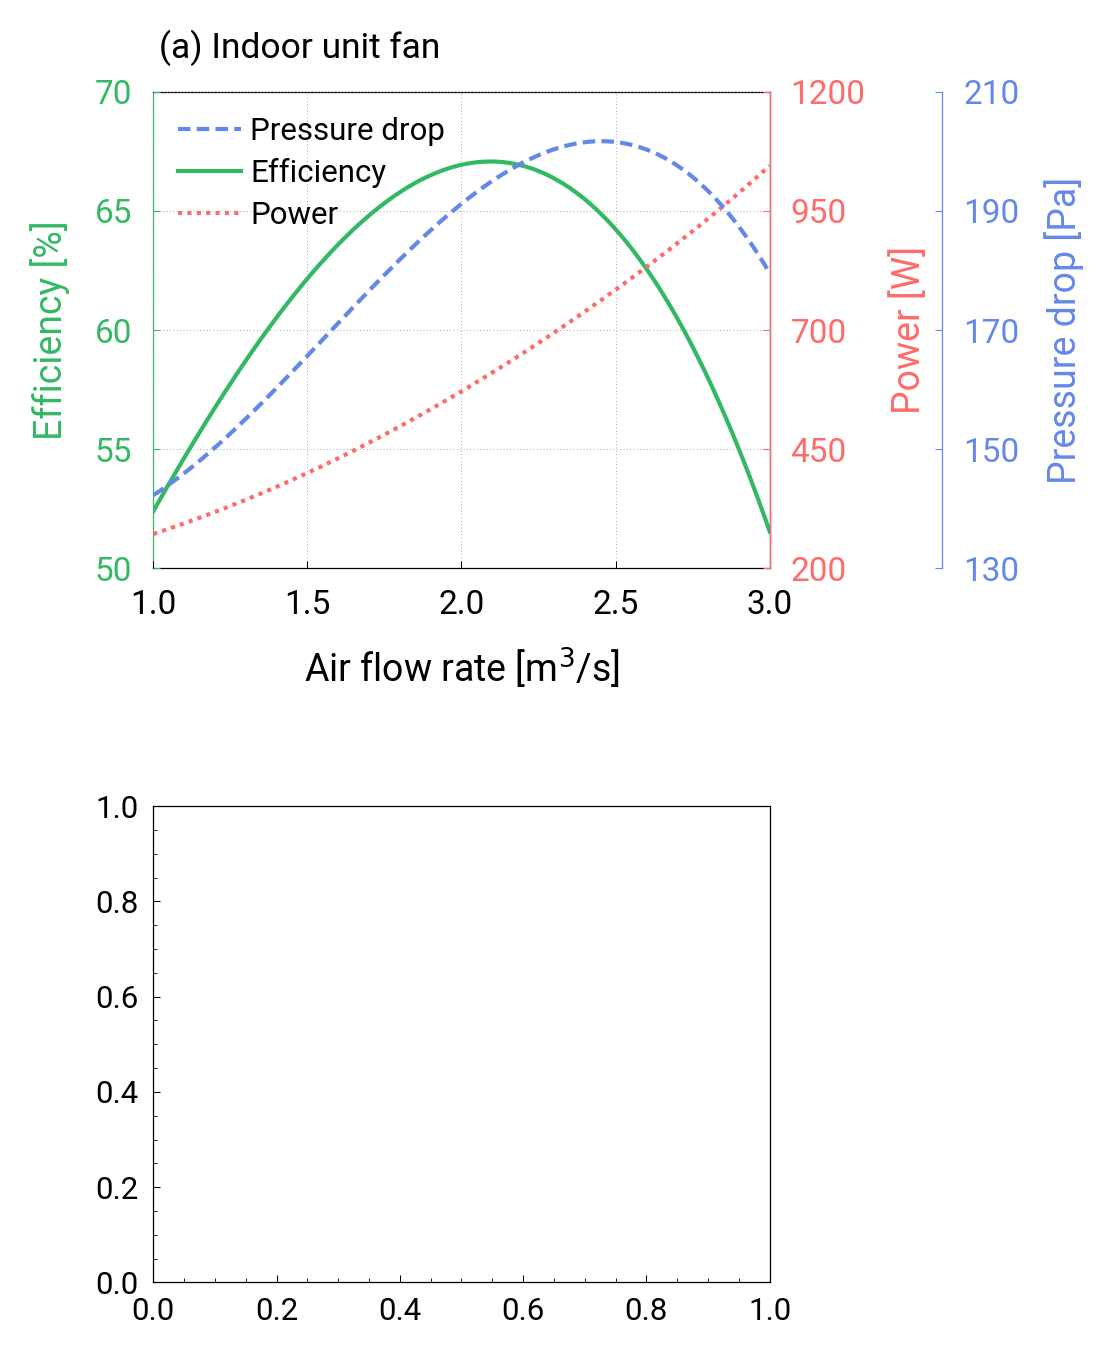

In [8]:
# Initialize the fan model from the enex_analysis library
# This model contains fan performance data for both indoor and outdoor units
fan_model = enex.Fan()

# Define air flow rate ranges for analysis
# Indoor unit: 1.0 to 3.0 m³/s
int_flow_range = np.linspace(1.0, 3.0, 100)
# Outdoor unit: 1.5 to 3.5 m³/s
ext_flow_range = np.linspace(1.5, 3.5, 100)

# Common settings for line width
line_width = 1.0

# Define colors for different parameters
colors = ['dm.soft blue', 'dm.cool green', 'dm.red5']  # Pressure, Efficiency, Power

# Create figure with two subplots (one for each fan)
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(9), dm.cm2in(12)))
plt.subplots_adjust(left=0.12, right=0.7, top=0.94, bottom=0.1, wspace=0.9, hspace=0.5)

# Define parameters for each fan type
fan_labels = ['Indoor unit', 'Outdoor unit']
flow_ranges = [int_flow_range, ext_flow_range]
# Y-axis limits and ticks for pressure drop [Pa]
ylim_pressure = [(130, 210), (250, 370)]
yticks_pressure = [np.linspace(130, 210, 5), np.linspace(250, 370, 5)]
# Y-axis limits and ticks for efficiency [%]
ylim_efficiency = [(50, 70), (50, 70)]
yticks_efficiency = [np.linspace(50, 70, 5), np.linspace(50, 70, 5)]
# Y-axis limits and ticks for power [W]
ylim_power = [(200, 1200), (600, 2200)]
yticks_power = [np.linspace(200, 1200, 5), np.linspace(600, 2200, 5)]
# X-axis limits and ticks
xlims = [(1.0, 3.0), (1.5, 3.5)]
xticks = [np.arange(1.0, 3.1, 0.5), np.arange(1.5, 3.6, 0.5)]

# Loop through each fan (indoor and outdoor)
for ax, fan, label, flow_range, ylim_p, yticks_p, ylim_e, yticks_e, ylim_pow, yticks_pow, xlim, xtick in zip(
    axes, fan_model.fan_list, fan_labels, flow_ranges, ylim_pressure, yticks_pressure, 
    ylim_efficiency, yticks_efficiency, ylim_power, yticks_power, xlims, xticks
):
    # Get fan performance characteristics from the model
    pressure = fan_model.get_pressure(fan, flow_range)      # Pressure drop [Pa]
    efficiency = fan_model.get_efficiency(fan, flow_range)   # Efficiency [dimensionless, 0-1]
    power = fan_model.get_power(fan, flow_range)             # Power consumption [W]

    # --- Left Y-axis: Efficiency ---
    ax.set_xlabel('Air flow rate [m$^3$/s]', fontsize=fs['label'], labelpad=pad['label'])
    ax.set_ylabel('Efficiency [%]', color=colors[1], fontsize=fs['label'], labelpad=pad['label'])
    # Plot efficiency (convert to percentage)
    eff_line, = ax.plot(flow_range, efficiency * 100, color=colors[1], linestyle='-', 
                        label='Efficiency', linewidth=line_width)
    ax.tick_params(axis='x', labelsize=fs['tick'], pad=pad['tick'])
    ax.tick_params(axis='y', labelsize=fs['tick'], colors=colors[1], pad=pad['tick'])
    ax.set_xlim(xlim)
    ax.set_xticks(xtick)
    ax.set_ylim(ylim_e)
    ax.set_yticks(yticks_e)
    ax.spines['left'].set_color(colors[1])  # Color left spine to match efficiency line

    # --- First right Y-axis: Power ---
    ax2 = ax.twinx()
    ax2.set_ylabel('Power [W]', color=colors[2], fontsize=fs['label'], labelpad=pad['label'])
    power_line, = ax2.plot(flow_range, power, color=colors[2], linestyle=':', 
                           label='Power', linewidth=line_width)
    ax2.tick_params(axis='y', labelsize=fs['tick'], colors=colors[2], pad=pad['tick'])
    ax2.set_ylim(ylim_pow)
    ax2.set_yticks(yticks_pow)
    # Hide unnecessary spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_color(colors[2])  # Color right spine to match power line

    # --- Second right Y-axis: Pressure drop ---
    ax3 = ax.twinx()
    # Position the second right axis further to the right
    ax3.spines['right'].set_position(('axes', 1.28))
    ax3.set_ylabel('Pressure drop [Pa]', color=colors[0], fontsize=fs['label'], labelpad=pad['label'])
    pressure_line, = ax3.plot(flow_range, pressure, color=colors[0], linestyle='--', 
                              label='Pressure drop', linewidth=line_width)
    ax3.tick_params(axis='y', labelsize=fs['tick'], colors=colors[0], pad=pad['tick'])
    ax3.set_ylim(ylim_p)
    ax3.set_yticks(yticks_p)
    # Hide unnecessary spines
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['right'].set_color(colors[0])  # Color right spine to match pressure line

    # Add grid
    ax.grid(True)

    # Remove minor ticks for cleaner appearance
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='y', which='minor', right=False)
    ax2.tick_params(axis='y', which='minor', right=False)
    ax3.tick_params(axis='y', which='minor', right=False)

    # Add subplot title
    ax.text(0.01, 1.13, f'({chr(97 + axes.tolist().index(ax))}) {label} fan',
            transform=ax.transAxes, fontsize=fs['subtitle'], va='top', ha='left')

    # Add legend with all three parameters
    lines = [eff_line, power_line, pressure_line]
    labels_ = [line.get_label() for line in lines]
    ax.legend([pressure_line, eff_line, power_line], 
              ['Pressure drop', 'Efficiency', 'Power'], 
              loc='upper left', fontsize=fs['legend'])

# Save the figure
plt.savefig('../figure/Fig. 7.png', dpi=600)
plt.savefig('../figure/Fig. 7.pdf', dpi=600)
dm.util.save_and_show(fig)


## Figure 9: Energy Efficiency (COP) Grid Analysis

This figure presents a grid-based analysis of system energy efficiency (COP) as a function of environmental temperature and load. The data is binned into grid cells, with each cell showing the average COP value. The top panel shows cooling mode performance, while the bottom panel shows heating mode performance. A vertical line indicates the setpoint temperature (22°C).


In [ ]:
# Define function to calculate average COP for each grid cell
# This function bins the data by temperature and load, then calculates mean COP for each bin
def grid_stats(Toa, Load, COP, bins_x, bins_y):
    """
    Calculate average COP for each grid cell defined by temperature and load bins.
    
    Parameters:
    - Toa: Array of outdoor air temperatures
    - Load: Array of loads (cooling or heating)
    - COP: Array of corresponding COP values
    - bins_x: Temperature bin edges
    - bins_y: Load bin edges
    
    Returns:
    - avg_COP: 2D array of average COP values for each grid cell
    - bins_x, bins_y: Bin edges (returned for convenience)
    """
    avg_COP = np.full((len(bins_y)-1, len(bins_x)-1), np.nan)
    for i in range(len(bins_x)-1):  # x-axis (temperature)
        for j in range(len(bins_y)-1):  # y-axis (load)
            # Create mask for data points within this grid cell
            mask = (
                (Toa >= bins_x[i]) & (Toa < bins_x[i+1]) &
                (Load >= bins_y[j]) & (Load < bins_y[j+1])
            )
            if np.any(mask):
                avg_COP[j,i] = np.mean(COP[mask])
    return avg_COP, bins_x, bins_y

# Load the processed weekday data
date_list = df['Date/Time_clean']
Toa_list = df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
cooling_load_list = df['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
heating_load_list = df['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

# Initialize lists to store calculated metrics
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []
ASHP_cooling_COP = []
ASHP_heating_COP = []

# Calculate COP and exergy efficiency for each hour
# Loop through all data points and compute system performance
for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # --- Cooling mode calculation ---
    if cooling_load > 0:
        # Initialize cooling ASHP model
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa  # Outdoor temperature
        ASHP_cooling.T_a_room = 22  # Room air temperature setpoint [°C]
        ASHP_cooling.Q_r_int = cooling_load  # Current cooling load [W]
        ASHP_cooling.Q_r_max = max(cooling_load_list)  # Maximum cooling load for normalization
        ASHP_cooling.system_update()  # Calculate system performance
        
        # Store results if exergy efficiency is valid (positive)
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(None)
            ASHP_cooling_COP.append(None)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
            ASHP_cooling_COP.append(ASHP_cooling.COP_sys)
    else:
        ASHP_cooling_exergy_effi.append(None)
        ASHP_cooling_COP.append(None)

    # --- Heating mode calculation ---
    if heating_load > 0:
        # Initialize heating ASHP model
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        
        # Store results if exergy efficiency is valid
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(None)
            ASHP_heating_COP.append(None)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
            ASHP_heating_COP.append(ASHP_heating.COP_sys)
    else:
        ASHP_heating_exergy_effi.append(None)
        ASHP_heating_COP.append(None)

# Filter out None values for COP (keep only valid data points)
ASHP_cooling_COP_filtered = [cop for cop in ASHP_cooling_COP if cop is not None]
ASHP_heating_COP_filtered = [cop for cop in ASHP_heating_COP if cop is not None]
ASHP_cooling_exergy_effi_filtered = [eff for eff in ASHP_cooling_exergy_effi if eff is not None]
ASHP_heating_exergy_effi_filtered = [eff for eff in ASHP_heating_exergy_effi if eff is not None]

# Filter corresponding temperature and load data (remove entries where COP is None)
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

# =========================
# Configuration parameters (all tunable in one place)
# =========================
# Colormap settings
CMAP_BASE_NAME       = 'coolwarm'
CMAP_LEFT_RANGE      = (0.00, 0.45)   # Range for cooling panel
CMAP_RIGHT_RANGE     = (0.55, 1.00)   # Range for heating panel
REVERSE_LEFT_CMAP    = True           # Whether to reverse cooling colormap

# Grid and range settings
BIN_TEMP             = 2.5            # Temperature bin size [°C]
BIN_LOAD             = 5.0            # Load bin size [kW]
X_RANGE              = (-10, 35)      # X-axis range (temperature) [°C]
Y_RANGE              = (0, 30)        # Y-axis range (load) [kW]

# COP scale (same for both panels)
COP_VMIN, COP_VMAX, COP_VTICK = 1.5, 4.0, 0.5

# Grid appearance
GRID_RECT_LW         = 1.0            # Grid rectangle line width
EDGE_COLOR_COOL      = 'white'         # Grid edge color for cooling
EDGE_COLOR_HEAT      = 'dm.white'     # Grid edge color for heating
MAJOR_GRID_LS        = '--'           # Major grid line style
MAJOR_GRID_ALPHA     = 0.5            # Major grid alpha
MINOR_X_LEN          = 1.6            # Minor tick length
MINOR_X_COLOR        = 'dm.gray7'     # Minor tick color

# Text color determination (based on background luminance)
LUMINANCE_CUTOFF     = 0.5            # Luminance threshold (0=black, 1=white)

# Setpoint line settings
SETPOINT_VALUE       = 22             # Setpoint temperature [°C]
SETPOINT_LS          = '--'           # Setpoint line style
SETPOINT_LW          = 0.6            # Setpoint line width
SETPOINT_COLOR       = 'dm.teal6'    # Setpoint line color
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8           # Setpoint text x position
SETPOINT_TX_Y        = 26.2           # Setpoint text y position
SETPOINT_TX_ROT      = 90             # Setpoint text rotation

# Figure layout
FIG_W_CM, FIG_H_CM   = 17, 12         # Figure dimensions [cm]
MARGINS              = dict(left=0.07, right=0.87, top=0.97, bottom=0.08)
HSPACE               = 0.3            # Horizontal space between subplots

# Colorbar settings
CBAR_W               = 0.018          # Colorbar width
CBAR_OFF_H           = 0.025          # Colorbar offset from axis

# Panel labels
PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# Prepare colormaps
# =========================
_coolwarm = cm.cm.get_cmap(CMAP_BASE_NAME)
coolwarm_left  = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left',  _coolwarm(np.linspace(*CMAP_LEFT_RANGE, 256))
)
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', _coolwarm(np.linspace(*CMAP_RIGHT_RANGE, 256))
)
CMAP_COOL = coolwarm_left.reversed() if REVERSE_LEFT_CMAP else coolwarm_left
CMAP_HEAT = coolwarm_right

# =========================
# Prepare data and bins
# =========================
# Cooling data
Toa_c  = np.array(Toa_cooling_list_filtered)
Load_c = np.array(cooling_load_list_filtered) / 1000.0  # Convert W to kW
COP_c  = np.array(ASHP_cooling_COP_filtered)

# Heating data
Toa_h  = np.array(Toa_heating_list_filtered)
Load_h = np.array(heating_load_list_filtered) / 1000.0  # Convert W to kW
COP_h  = np.array(ASHP_heating_COP_filtered)

# Create bin edges
bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

# Calculate average COP for each grid cell
avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, COP_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, COP_h, bins_x, bins_y)

# =========================
# Create plots
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# Panel parameters (for loop)
panels = [
    dict(ax_idx=0, avg=avg_c, cmap=CMAP_COOL, edge_color=EDGE_COLOR_COOL,
         y_label='Cooling load [kW]', tag=PANEL_A),
    dict(ax_idx=1, avg=avg_h, cmap=CMAP_HEAT, edge_color=EDGE_COLOR_HEAT,
         y_label='Heating load [kW]', tag=PANEL_B),
]

for p in panels:
    ax = axes[p['ax_idx']]

    # Main raster plot (pcolormesh)
    im = ax.pcolormesh(xedges, yedges, p['avg'], cmap=p['cmap'], vmin=COP_VMIN, vmax=COP_VMAX)

    # Normalization and colormap for text color determination
    _norm = mcolors.Normalize(vmin=COP_VMIN, vmax=COP_VMAX)
    _cmap_for_text = p['cmap']

    # Add grid rectangles and cell values
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            # Draw grid rectangle
            ax.add_patch(plt.Rectangle(
                (xedges[i], yedges[j]),
                xedges[i+1] - xedges[i],
                yedges[j+1] - yedges[j],
                linewidth=GRID_RECT_LW,
                edgecolor=p['edge_color'],
                facecolor='none',
                zorder=1
            ))
            # Add cell value text
            val = p['avg'][j, i]
            if not np.isnan(val):
                # Determine text color based on background luminance
                # Calculate relative luminance (0=black, 1=white)
                r, g, b, _ = _cmap_for_text(_norm(val))
                luminance = 0.2126*r + 0.7152*g + 0.0722*b
                txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

                ax.text(
                    (xedges[i] + xedges[i+1]) / 2.0,
                    (yedges[j] + yedges[j+1]) / 2.0,
                    f"{val:.1f}", ha='center', va='center',
                    fontsize=fs['text'], color=txt_color
                )

    # Axis labels and ticks
    ax.set_ylabel(p['y_label'], fontsize=fs['label'], labelpad=pad['label'])
    ax.minorticks_off()
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

    # Setpoint line and text
    ax.axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
    ax.text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
            fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')

    # Panel tag
    ax.text(0.01, 0.97, p['tag'], transform=ax.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

    # Colorbar (positioned outside each axis)
    bbox = ax.get_position()
    cb_ax = fig.add_axes([bbox.x1 + CBAR_OFF_H, bbox.y0, CBAR_W, bbox.y1 - bbox.y0])
    cbar  = fig.colorbar(im, cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(direction='in', labelsize=fs['cbar_tick'], pad=pad['tick'])
    cbar.set_ticks(np.arange(COP_VMIN, COP_VMAX + 1e-9, COP_VTICK))
    cbar.ax.minorticks_off()
    cbar.ax.set_ylabel('Energy efficiency (COP$_{sys}$) [ - ]',
                       rotation=90, fontsize=fs['cbar_label'], labelpad=pad['label'], loc='center')

# Common axis/grid/tick settings
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR)

# Save and display
plt.savefig('../figure/Fig. 9.png', dpi=600)
plt.savefig('../figure/Fig. 9.pdf', dpi=600)
dm.util.save_and_show(fig)


AttributeError: 'AirSourceHeatPump_heating' object has no attribute 'COP_sys'

## Figure 10: Exergy Efficiency Grid Analysis

This figure presents a grid-based analysis of system exergy efficiency as a function of environmental temperature and load. Similar to Figure 9, the data is binned into grid cells showing average exergy efficiency values. The top panel shows cooling mode performance, while the bottom panel shows heating mode performance. Exergy efficiency is displayed as a percentage.


In [ ]:
# Use the same grid_stats function as in Figure 9
# (Function definition is the same, so we can reuse it)

# Load data (same as Figure 9)

date_list = df['Date/Time_clean']
Toa_list = df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
cooling_load_list = df['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
heating_load_list = df['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

# Calculate exergy efficiency and COP (same calculation as Figure 9)
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []
ASHP_cooling_COP = []
ASHP_heating_COP = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    # Cooling mode calculation
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(None)
            ASHP_cooling_COP.append(None)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
            ASHP_cooling_COP.append(ASHP_cooling.COP_sys)
    else:
        ASHP_cooling_exergy_effi.append(None)
        ASHP_cooling_COP.append(None)

    # Heating mode calculation
    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(None)
            ASHP_heating_COP.append(None)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
            ASHP_heating_COP.append(ASHP_heating.COP_sys)
    else:
        ASHP_heating_exergy_effi.append(None)
        ASHP_heating_COP.append(None)

# Filter data (same as Figure 9)
ASHP_cooling_COP_filtered = [cop for cop in ASHP_cooling_COP if cop is not None]
ASHP_heating_COP_filtered = [cop for cop in ASHP_heating_COP if cop is not None]
ASHP_cooling_exergy_effi_filtered = [eff for eff in ASHP_cooling_exergy_effi if eff is not None]
ASHP_heating_exergy_effi_filtered = [eff for eff in ASHP_heating_exergy_effi if eff is not None]

Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

# =========================
# Configuration parameters
# =========================
# Colormap settings
CMAP_BASE_NAME       = 'coolwarm'
CMAP_LEFT_RANGE      = (0.00, 0.45)
CMAP_RIGHT_RANGE     = (0.55, 1.00)
REVERSE_LEFT_CMAP    = True

# Grid and range settings
BIN_TEMP             = 2.5
BIN_LOAD             = 5.0
X_RANGE              = (-10, 35)
Y_RANGE              = (0, 30)

# Exergy efficiency scale (different for cooling and heating, in %)
COOL_VMIN, COOL_VMAX, COOL_VTICK = 0, 20, 5
HEAT_VMIN, HEAT_VMAX, HEAT_VTICK = 0, 32, 8

# Grid appearance
GRID_RECT_LW         = 1.0
EDGE_COLOR_COOL      = 'white'
EDGE_COLOR_HEAT      = 'dm.white'
MAJOR_GRID_LS        = '--'
MAJOR_GRID_ALPHA     = 0.5
MINOR_X_LEN          = 1.6
MINOR_X_COLOR        = 'dm.gray7'

# Text color determination
LUMINANCE_CUTOFF     = 0.5

# Setpoint settings
SETPOINT_VALUE       = 22
SETPOINT_LS          = '--'
SETPOINT_LW          = 0.6
SETPOINT_COLOR       = 'dm.teal6'
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8
SETPOINT_TX_Y        = 26.2
SETPOINT_TX_ROT      = 90

# Figure layout
FIG_W_CM, FIG_H_CM   = 17, 12
MARGINS              = dict(left=0.07, right=0.87, top=0.97, bottom=0.08)
HSPACE               = 0.3

CBAR_W               = 0.018
CBAR_OFF_H           = 0.025

PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# Prepare colormaps
# =========================
_coolwarm = cm.cm.get_cmap(CMAP_BASE_NAME)
coolwarm_left  = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_left',  _coolwarm(np.linspace(*CMAP_LEFT_RANGE, 256))
)
coolwarm_right = mcolors.LinearSegmentedColormap.from_list(
    'coolwarm_right', _coolwarm(np.linspace(*CMAP_RIGHT_RANGE, 256))
)
CMAP_COOL = coolwarm_left.reversed() if REVERSE_LEFT_CMAP else coolwarm_left
CMAP_HEAT = coolwarm_right

# =========================
# Prepare data and bins
# =========================
# Cooling data (convert exergy efficiency to percentage)
Toa_c   = np.array(Toa_cooling_list_filtered)
Load_c  = np.array(cooling_load_list_filtered) / 1000.0
X_eff_c = np.array(ASHP_cooling_exergy_effi_filtered) * 100.0  # Convert to [%]

# Heating data (convert exergy efficiency to percentage)
Toa_h   = np.array(Toa_heating_list_filtered)
Load_h  = np.array(heating_load_list_filtered) / 1000.0
X_eff_h = np.array(ASHP_heating_exergy_effi_filtered) * 100.0  # Convert to [%]

bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

# Calculate average exergy efficiency (%) for each grid cell
avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, X_eff_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, X_eff_h, bins_x, bins_y)

# =========================
# Create plots
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# Panel parameters
panels = [
    dict(ax_idx=0, avg=avg_c, cmap=CMAP_COOL, vmin=COOL_VMIN, vmax=COOL_VMAX,
         y_label='Cooling load [kW]', edge_color=EDGE_COLOR_COOL,
         cbar_ticks=np.arange(COOL_VMIN, COOL_VMAX + 1e-9, COOL_VTICK),
         panel_tag=PANEL_A),
    dict(ax_idx=1, avg=avg_h, cmap=CMAP_HEAT, vmin=HEAT_VMIN, vmax=HEAT_VMAX,
         y_label='Heating load [kW]', edge_color=EDGE_COLOR_HEAT,
         cbar_ticks=np.arange(HEAT_VMIN, HEAT_VMAX + 1e-9, HEAT_VTICK),
         panel_tag=PANEL_B),
]

for p in panels:
    ax = axes[p['ax_idx']]
    im = ax.pcolormesh(xedges, yedges, p['avg'], cmap=p['cmap'], vmin=p['vmin'], vmax=p['vmax'])

    # Normalization and colormap for text color determination
    _norm = mcolors.Normalize(vmin=p['vmin'], vmax=p['vmax'])
    _cmap_for_text = p['cmap']

    # Add grid rectangles and cell values
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            ax.add_patch(plt.Rectangle(
                (xedges[i], yedges[j]),
                xedges[i+1] - xedges[i],
                yedges[j+1] - yedges[j],
                linewidth=GRID_RECT_LW,
                edgecolor=p['edge_color'],
                facecolor='none',
                zorder=1
            ))
            val = p['avg'][j, i]
            if not np.isnan(val):
                # Determine text color based on background luminance
                r, g, b, _ = _cmap_for_text(_norm(val))
                luminance = 0.2126*r + 0.7152*g + 0.0722*b
                txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

                ax.text(
                    (xedges[i] + xedges[i+1]) / 2.0,
                    (yedges[j] + yedges[j+1]) / 2.0,
                    f"{val:.1f}", ha='center', va='center',
                    fontsize=fs['text'], color=txt_color
                )

    # Axis labels
    ax.set_ylabel(p['y_label'], fontsize=fs['label'], labelpad=pad['label'])
    ax.minorticks_off()

    # Setpoint line and text
    ax.axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
    ax.text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
            fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')

    # Panel tag
    ax.text(0.01, 0.97, p['panel_tag'], transform=ax.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')
    
    # Colorbar
    bbox = ax.get_position()
    cb_ax = fig.add_axes([bbox.x1 + CBAR_OFF_H, bbox.y0, CBAR_W, bbox.y1 - bbox.y0])
    cbar  = fig.colorbar(im, cax=cb_ax, orientation='vertical')
    cbar.ax.tick_params(direction='in', labelsize=fs['cbar_tick'], pad=pad['tick'])
    cbar.set_ticks(np.arange(COOL_VMIN, COOL_VMAX + 1e-9, COOL_VTICK) if p['ax_idx'] == 0 else np.arange(HEAT_VMIN, HEAT_VMAX + 1e-9, HEAT_VTICK))
    cbar.ax.minorticks_off()
    cbar.ax.set_ylabel('Exergy efficiency ($\eta_{X,sys}$) [ - ]',
                       rotation=90, fontsize=fs['cbar_label'], labelpad=pad['label'], loc='center')

# Common axis/grid/tick settings
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR)
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

# Save and display
plt.savefig('../figure/Fig. 10.png', dpi=600)
plt.savefig('../figure/Fig. 10.pdf', dpi=600)
dm.util.save_and_show(fig)


## Figure 11: Carnot Efficiency Grid Analysis

This figure presents a grid-based analysis of Carnot efficiency (1 - T₀/T_set) as a function of environmental temperature and load. The Carnot efficiency represents the theoretical maximum efficiency for a heat pump operating between the environmental temperature (T₀) and the setpoint temperature (T_set = 22°C). The top panel shows cooling mode, while the bottom panel shows heating mode. A shared colorbar spans both panels.


In [ ]:
# Use the same grid_stats function and data loading as previous figures
# (Function definition is the same)

# Load data
date_list = df['Date/Time_clean']
Toa_list = df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
cooling_load_list = df['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
heating_load_list = df['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

# Calculate exergy efficiency to filter valid data points (same as Figure 9/10)
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []

for Toa, cooling_load, heating_load in zip(Toa_list, cooling_load_list, heating_load_list):
    if cooling_load > 0:
        ASHP_cooling = enex.AirSourceHeatPump_cooling()
        ASHP_cooling.T0 = Toa
        ASHP_cooling.T_a_room = 22
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.Q_r_max = max(cooling_load_list)
        ASHP_cooling.system_update()
        if ASHP_cooling.X_eff < 0:
            ASHP_cooling_exergy_effi.append(None)
        else:          
            ASHP_cooling_exergy_effi.append(ASHP_cooling.X_eff)
    else:
        ASHP_cooling_exergy_effi.append(None)

    if heating_load > 0:
        ASHP_heating = enex.AirSourceHeatPump_heating()
        ASHP_heating.T0 = Toa
        ASHP_heating.T_a_room = 22
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.Q_r_max = max(heating_load_list)
        ASHP_heating.system_update() 
        if ASHP_heating.X_eff < 0:
            ASHP_heating_exergy_effi.append(None)
        else:
            ASHP_heating_exergy_effi.append(ASHP_heating.X_eff)
    else:
        ASHP_heating_exergy_effi.append(None)

# Filter data (keep only valid data points)
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]

# =========================
# Configuration parameters
# =========================
CMAP_NAME            = 'coolwarm'
C_MIN, C_MAX, C_INT  = -0.1, 0.1, 0.02  # Carnot efficiency range
BIN_TEMP             = 2.5
BIN_LOAD             = 5.0
X_RANGE              = (-10, 35)
Y_RANGE              = (0, 30)

GRID_RECT_LW         = 1.0
EDGE_COLOR_COOL      = 'white'
EDGE_COLOR_HEAT      = 'dm.white'
MAJOR_GRID_LS        = '--'
MAJOR_GRID_ALPHA     = 0.5
MINOR_X_LEN          = 1.6
MINOR_X_COLOR        = 'dm.gray7'

LUMINANCE_CUTOFF     = 0.5

SETPOINT_VALUE       = 22
SETPOINT_LS          = '--'
SETPOINT_LW          = 0.6
SETPOINT_COLOR       = 'dm.teal6'
SETPOINT_TEXT        = 'Setpoint'
SETPOINT_TX_X        = 20.8
SETPOINT_TX_Y        = 26.2
SETPOINT_TX_ROT      = 90

FIG_W_CM, FIG_H_CM   = 17, 13
MARGINS              = dict(left=0.07, right=0.87, top=0.97, bottom=0.08)
HSPACE               = 0.3

CBAR_W               = 0.018
CBAR_OFF_H           = 0.03

PANEL_A              = '(a)'
PANEL_B              = '(b)'

# =========================
# Prepare data and bins
# =========================
# Cooling data
Toa_c   = np.array(Toa_cooling_list_filtered)
Load_c  = np.array(cooling_load_list_filtered) / 1000.0
# Calculate Carnot efficiency: 1 - T₀/T_set
# For cooling: efficiency is negative when T₀ > T_set (heat rejection to hotter environment)
Carnot_eff_c = 1 - enex.C2K(np.array(Toa_cooling_list_filtered)) / enex.C2K(SETPOINT_VALUE)

# Heating data
Toa_h   = np.array(Toa_heating_list_filtered)
Load_h  = np.array(heating_load_list_filtered) / 1000.0
# For heating: efficiency is positive when T₀ < T_set (heat extraction from colder environment)
Carnot_eff_h = 1 - enex.C2K(np.array(Toa_heating_list_filtered)) / enex.C2K(SETPOINT_VALUE)

bins_x = np.arange(X_RANGE[0], X_RANGE[1] + BIN_TEMP, BIN_TEMP)
bins_y = np.arange(Y_RANGE[0], Y_RANGE[1] + BIN_LOAD, BIN_LOAD)

# Calculate average Carnot efficiency for each grid cell
avg_c, xedges, yedges = grid_stats(Toa_c, Load_c, Carnot_eff_c, bins_x, bins_y)
avg_h, _,      _      = grid_stats(Toa_h, Load_h, Carnot_eff_h, bins_x, bins_y)

# =========================
# Create plots
# =========================
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)), sharex=False, sharey=True)
plt.subplots_adjust(**MARGINS, hspace=HSPACE)

# Normalization and colormap for text color determination
_norm = mcolors.Normalize(vmin=C_MIN, vmax=C_MAX)
_cmap = cm.cm.get_cmap(CMAP_NAME)

# --- (a) Cooling ---
im1 = axes[0].pcolormesh(xedges, yedges, avg_c, cmap=CMAP_NAME, vmin=C_MIN, vmax=C_MAX)
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[0].add_patch(plt.Rectangle(
            (xedges[i], yedges[j]),
            xedges[i+1] - xedges[i],
            yedges[j+1] - yedges[j],
            linewidth=GRID_RECT_LW,
            edgecolor=EDGE_COLOR_COOL,
            facecolor='none',
            zorder=1
        ))
        val = avg_c[j, i]
        if not np.isnan(val):
            # Determine text color based on background luminance
            r, g, b, _ = _cmap(_norm(val))
            luminance = 0.2126*r + 0.7152*g + 0.0722*b
            txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

            axes[0].text(
                (xedges[i] + xedges[i+1]) / 2.0,
                (yedges[j] + yedges[j+1]) / 2.0,
                f"{val:.2f}", ha='center', va='center',
                fontsize=fs['text'], color=txt_color
            )
axes[0].set_ylabel('Cooling load [kW]', fontsize=fs['label'], labelpad=pad['label'])
axes[0].tick_params(axis='both', which='major', labelsize=fs['tick'])
axes[0].minorticks_off()
axes[0].axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
axes[0].text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
             fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')
axes[0].text(0.01, 0.97, PANEL_A, transform=axes[0].transAxes,
             fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# --- (b) Heating ---
im2 = axes[1].pcolormesh(xedges, yedges, avg_h, cmap=CMAP_NAME, vmin=C_MIN, vmax=C_MAX)
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[1].add_patch(plt.Rectangle(
            (xedges[i], yedges[j]),
            xedges[i+1] - xedges[i],
            yedges[j+1] - yedges[j],
            linewidth=GRID_RECT_LW,
            edgecolor=EDGE_COLOR_HEAT,
            facecolor='none',
            zorder=1
        ))
        val = avg_h[j, i]
        if not np.isnan(val):
            # Same logic for text color
            r, g, b, _ = _cmap(_norm(val))
            luminance = 0.2126*r + 0.7152*g + 0.0722*b
            txt_color = 'white' if luminance < LUMINANCE_CUTOFF else 'black'

            axes[1].text(
                (xedges[i] + xedges[i+1]) / 2.0,
                (yedges[j] + yedges[j+1]) / 2.0,
                f"{val:.2f}", ha='center', va='center',
                fontsize=fs['text'], color=txt_color
            )
axes[1].set_ylabel('Heating load [kW]', fontsize=fs['label'], labelpad=pad['label'])
axes[1].tick_params(axis='both', which='major', labelsize=fs['tick'])
axes[1].minorticks_off()
axes[1].axvline(x=SETPOINT_VALUE, color=SETPOINT_COLOR, linestyle=SETPOINT_LS, linewidth=SETPOINT_LW)
axes[1].text(SETPOINT_TX_X, SETPOINT_TX_Y, SETPOINT_TEXT, rotation=SETPOINT_TX_ROT,
             fontsize=fs['setpoint'], color=SETPOINT_COLOR, ha='left', va='center')
axes[1].text(0.01, 0.97, PANEL_B, transform=axes[1].transAxes,
             fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# --- Common axis/grid/tick settings ---
for ax in axes:
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_xlabel('Environmental temperature [$^{\\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
    ax.grid(True, linestyle=MAJOR_GRID_LS, alpha=MAJOR_GRID_ALPHA)
    ax.set_xticks(xedges, minor=True)
    ax.tick_params(axis='x', which='minor', length=MINOR_X_LEN, color=MINOR_X_COLOR, pad=pad['tick'])

# --- Shared colorbar ---
# Position colorbar to span both subplots
bbox_top  = axes[0].get_position()
bbox_bot  = axes[1].get_position()
cb_ax = fig.add_axes([bbox_bot.x1 + CBAR_OFF_H, bbox_bot.y0, CBAR_W, bbox_top.y1 - bbox_bot.y0])
cbar = fig.colorbar(im1, cax=cb_ax, orientation='vertical')
cbar.ax.tick_params(direction='in', labelsize=fs['cbar_tick'], pad=pad['tick'])
cbar.set_ticks(np.arange(C_MIN, C_MAX + 1e-12, C_INT))
cbar.ax.minorticks_off()
cbar.ax.set_ylabel('Carnot efficiency ($1 - T_0/T_{set}$) [ - ]',
                   rotation=90, fontsize=fs['cbar_label'], labelpad=pad['label'], loc='center')

# Save and display
plt.savefig('../figure/Fig. 11.png', dpi=600)
plt.savefig('../figure/Fig. 11.pdf', dpi=600)
dm.util.save_and_show(fig)


NameError: name 'df' is not defined

## Figure 12: Exergy Rate per Unit Air Flow

This figure shows the exergy rate per unit air flow rate as a function of indoor air temperature. The exergy rate represents the available work that can be extracted from the air stream. Two scenarios are shown: winter operation (with T₀ = -6°C) and summer operation (with T₀ = 33°C), demonstrating how the reference temperature affects exergy availability.


In [ ]:
# Define minor tick settings
x_minor_between = 1   # Number of minor ticks between major ticks on X-axis
y_minor_between = 1   # Number of minor ticks between major ticks on Y-axis

# Define axis ranges and intervals
xmin, xmax, xint, xmar = -10, 40, 5, 0
ymin, ymax, yint, ymar =  0, 5, 1, 0

# Physical constants for air properties
c_a = 1005      # Specific heat capacity of air [J/kgK]
rho_a = 1.225   # Density of air [kg/m³]
k_a = 0.0257    # Thermal conductivity of air [W/mK]

# Create temperature range for plotting
T_range = np.arange(xmin, xmax+xint, 0.1)
T_a_int_in = 22  # Indoor air inlet temperature [°C]

# Define reference temperatures (environmental temperatures) for two scenarios
T0_cooling = -6   # Winter reference temperature [°C]
T0_heating = 33   # Summer reference temperature [°C]
T0 = np.array([T0_cooling, T0_heating])

# Convert temperatures to Kelvin for calculations
T_range_K = enex.C2K(T_range)
T0_K = enex.C2K(T0)

# Calculate exergy rate per unit air flow
# Exergy rate formula: c_a * rho_a * dV * [(T - T0) - T0 * ln(T/T0)]
# This represents the available work from the temperature difference
dV_int_unit = 1  # Unit air flow rate [m³/s] (for normalization)

# Calculate exergy rate for winter scenario (cooling mode, T0 = -6°C)
y1 = (c_a * rho_a * dV_int_unit * 
      ((T_range_K - T0_K[0]) - T0_K[0] * np.log(T_range_K / T0_K[0])) * enex.W2kW)

# Calculate exergy rate for summer scenario (heating mode, T0 = 33°C)
y2 = (c_a * rho_a * dV_int_unit * 
      ((T_range_K - T0_K[1]) - T0_K[1] * np.log(T_range_K / T0_K[1])) * enex.W2kW)

# Setpoint temperature
T_set = 22
T_a_int_out_cooling = 12  # Internal unit outlet air temp for cooling [°C]
T_a_int_out_heating = 32  # Internal unit outlet air temp for heating [°C]

# Create figure
fig = plt.figure(
    figsize=(dm.cm2in(14), dm.cm2in(7)),
    dpi=300
)

# Create GridSpec layout
nrows, ncols = 1, 1
gs = fig.add_gridspec(
    nrows=nrows, ncols=ncols,
    left=0.16, right=0.98, top=0.96, bottom=0.18,
    hspace=0.10, wspace=0.10
)

# Create subplot
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])

        # Plot exergy rate curves
        lw = 1
        line1, = ax.plot(
            T_range, y1, 
            c='dm.red4', lw=lw, label=f'In winter ($T_0$ = - {abs(T0_cooling)} °C)',
        )
        line2, = ax.plot(
            T_range, y2,
            c='dm.blue3', lw=lw, label=f'In summer ($T_0$ = {T0_heating} °C)',
        )
        
        # Add setpoint vertical line
        ds_lw = 0.5  # Dashed line width
        c1 = 'dm.teal'
        ax.axvline(x=T_set, color=c1 + '6', linestyle='--', linewidth=ds_lw, zorder=0)

        # Add setpoint label
        dx = -0.3
        ax.text(T_set + dx, ymax*0.95, 'Setpoint', rotation=90, 
                fontsize=fs['setpoint'], color=c1 + '6', ha='right', va='top')

        # Calculate and plot intersection points at setpoint
        ss = 6  # Scatter size
        sc1 = 'dm.red8'
        sc2 = 'dm.blue8'
        y1_at_T_set = np.interp(T_set, T_range, y1)
        y2_at_T_set = np.interp(T_set, T_range, y2)
        ax.scatter([T_set, T_set], [y1_at_T_set, y2_at_T_set], 
                   color=[sc1, sc2], s=ss, zorder=5)

        # Add value annotations at intersection points
        for x, y, col in [(T_set, y1_at_T_set, sc1), (T_set, y2_at_T_set, sc2)]:
            ax.annotate(
                f"{y:.2f}",
                (x, y),
                textcoords="offset points",
                xytext=(0, 4),           # Offset above point
                ha="center",
                va="bottom",
                fontsize=fs['text']+1,
                color=col,
                zorder=6
            )

        # Calculate additional intersection points (for reference, not plotted)
        y1_at_T_a_int_out_heating = np.interp(T_a_int_out_heating, T_range, y1)
        y2_at_T_a_int_out_cooling = np.interp(T_a_int_out_cooling, T_range, y2)
        
        # Calculate differences (for potential future use)
        y1_dy = y1_at_T_a_int_out_heating - y1_at_T_set
        y2_dy = y2_at_T_a_int_out_cooling - y2_at_T_set

        # Configure axes
        ax.set_xlabel('Indoor air temperature [°C]', labelpad=pad['label'], fontsize=fs['label'])
        ax.set_ylabel('Exergy rate per unit air flow [kW/(m$^3$/s)]', 
                     labelpad=pad['label'], fontsize=fs['label'])
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        ax.set_xticks(np.arange(xmin, xmax + 1, xint))
        ax.set_yticks(np.arange(ymin, ymax + 1, yint))
        
        ax.tick_params(axis='both', which='major', direction='in', 
                      pad=pad['tick'], labelsize=fs['tick'])
        ax.tick_params(axis='both', which='minor', direction='in', 
                      pad=pad['tick'], labelsize=fs['tick'])
        
        # Set minor tick locators
        ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_between + 1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_between + 1))

        # Add grid
        ax.grid(True, which='major', alpha=0.25)

        # Add legend
        handles = [line1, line2]
        labels = [h.get_label() for h in handles]
        ax.legend(handles, labels, loc='upper left', fontsize=fs['legend'], 
                 frameon=False, handletextpad=0.5)

# Optimize layout
dm.simple_layout(fig)
plt.savefig('../figure/Fig. 12.png', dpi=600)
plt.savefig('../figure/Fig. 12.svg', dpi=600, transparent=True)

dm.save_and_show(fig)


NameError: name 'np' is not defined

## Figure 13: January and August Hourly Analysis

This figure provides a detailed hourly analysis for two representative days: January 9th (winter, heating mode) and August 9th (summer, cooling mode). Each month is shown with two panels: the top panel displays environmental temperature and load, while the bottom panel shows energy efficiency (COP) and exergy efficiency over the course of the day.


In [ ]:
# Load the processed weekday data

# Define months to analyze and their starting days
# This analysis focuses on specific representative days from different months
months_to_plot = [1, 4, 8, 10]  # January, April, August, October
start_map = {1: 9, 4: 10, 8: 9, 10: 10}  # Starting day for each month

analyze_days = 1  # Number of days to analyze from the start day

# Extract day and month information from the date/time column
day_all = weekday_df['Date/Time_clean'].str.slice(3, 5).astype(int)  # Extract day (DD)
month_s = weekday_df['Month']  # Month column
start_day = month_s.map(start_map)  # Map starting day for each month
end_day = start_day + analyze_days

# Create a mask to filter data for the specified days
mask = (
    month_s.isin(months_to_plot) &
    day_all.ge(start_day) &
    day_all.le(end_day-1)
)
# Include the previous day's 24:00 hour to ensure continuity
mask = mask | mask.shift(-1, fill_value=False)

# Create subset dataframe for analysis
df_sub = weekday_df.loc[mask].copy()

# Add auxiliary columns for plotting
df_sub['Day'] = day_all[mask].values
hour_sub = df_sub['Date/Time_clean'].str.slice(6, 8).astype(int)  # Extract hour (HH)
df_sub['xpos'] = df_sub['Day'] + hour_sub / 24.0  # Continuous x-axis position

# Calculate maximum loads for normalization (used in system calculations)
Q_r_max_cooling = (df_sub['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h).max()
Q_r_max_heating = (df_sub['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h).max()

# Function to compute COP and exergy efficiency for each row
def compute_metrics(row):
    """
    Calculate COP and exergy efficiency for a given data row.
    
    Parameters:
    - row: DataFrame row containing temperature and load data
    
    Returns:
    - pd.Series with 'COP' and 'ExergyEff' values
    """
    Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
    cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
    heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

    exergy_effi = 0.0
    cop = 0.0

    # Calculate for cooling mode if cooling load exists
    if cooling_load > 0:
        ASHP = enex.AirSourceHeatPump_cooling()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22  # Room setpoint temperature [°C]
        ASHP.Q_r_int = cooling_load
        ASHP.Q_r_max = Q_r_max_cooling
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0  # Convert to percentage
            cop = ASHP.COP_sys

    # Calculate for heating mode if heating load exists
    elif heating_load > 0:
        ASHP = enex.AirSourceHeatPump_heating()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22
        ASHP.Q_r_int = heating_load
        ASHP.Q_r_max = Q_r_max_heating
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0  # Convert to percentage
            cop = ASHP.COP_sys

    return pd.Series({'COP': cop, 'ExergyEff': exergy_effi})

# Apply the computation function to all rows
df_sub[['COP', 'ExergyEff']] = df_sub.apply(compute_metrics, axis=1)

# =========================
# Configuration parameters (all tunable in one place)
# =========================
# X-axis settings
X_STEP_HR         = 1  # Hourly step size
XMIN              = 0
XMAX              = 24 * analyze_days
XMAJOR_INT        = 6  # Major tick interval [hours]
XMINOR_PER_MAJOR  = 1  # Number of minor ticks between major ticks

# Y-axis ranges and ticks
TEMP_YMIN,   TEMP_YMAX,   TEMP_YTICK   = -10, 40, 10  # Temperature [°C]
LOAD_YMIN,   LOAD_YMAX,   LOAD_YTICK   = 0,   25, 5   # Load [kW]
COP_YMIN,    COP_YMAX,    COP_YTICK    = 0,   5,  1   # COP [dimensionless]
EXGY_YMIN,   EXGY_YMAX,   EXGY_YTICK   = 0,   50, 10  # Exergy efficiency [%]

# Color scheme
COLOR_TEMP       = 'dm.teal6'    # Environmental temperature
COLOR_LOAD_HEAT  = 'dm.red5'     # Heating load
COLOR_LOAD_COOL  = 'dm.blue5'    # Cooling load
COLOR_COP        = 'dm.orange4'  # COP
COLOR_EXERGY     = 'dm.violet6'  # Exergy efficiency
COLOR_SETPOINT   = 'dm.teal6'    # Setpoint line

# Line and style settings
LINEWIDTH_MAIN   = 0.7           # Main line width
LINEWIDTH_SPINE  = 0.6           # Spine line width
ALPHA_FILL_LOAD  = 0.30          # Load fill area transparency
ALPHA_SETPOINT   = 0.70          # Setpoint line transparency
SETPOINT_VALUE   = 22            # Setpoint temperature [°C]

# Y-axis label fixed coordinates (left/right shared)
YLABEL_X_LEFT, YLABEL_X_RIGHT, YLABEL_Y = -0.13, 1.13, 0.5

# Month labels and layout
MONTH_NAME = ['January 9th', 'August 9th']  # Month labels for panels
LAYOUT     = [1, 8]                          # Left: January, Right: August
HEATING_MONTHS = (1, 10)                     # Months that use heating mode

# Figure layout settings
FIG_W_CM, FIG_H_CM = 17, 10                 # Figure dimensions [cm]
OUTER_WSPACE, OUTER_HSPACE = 0.55, 0.3      # Spacing between outer panels
INNER_HSPACE = 0.25                          # Spacing between inner panels
MARGINS = dict(left=0.08, right=0.92, top=0.94, bottom=0.1)

# =========================
# Create hour coordinates
# =========================
x_hour = np.arange(0, XMAX * 1.001, X_STEP_HR)

# =========================
# Create figure with GridSpec layout
# =========================
fig = plt.figure(figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)))
outer = gridspec.GridSpec(1, 2, figure=fig, wspace=OUTER_WSPACE, hspace=OUTER_HSPACE)

# =========================
# Loop through months (top/bottom panels)
# =========================
for c in range(2):
    month = LAYOUT[c]
    # Filter data for this month and sort by xpos
    mdf   = df_sub[df_sub['Month'] == month].sort_values('xpos')
    start = start_map[month]
    end   = start + 1

    # Create inner GridSpec for two rows (top/bottom) within each month column
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[c], hspace=INNER_HSPACE)
    ax_top = fig.add_subplot(inner[0, 0])
    ax_bot = fig.add_subplot(inner[1, 0], sharex=ax_top)

    # -------------------------
    # Top panel: Environmental temperature (left) + Load (right)
    # -------------------------
    ax1 = ax_top
    ax2 = ax1.twinx()  # Create second y-axis for load

    # Select load type based on month (heating or cooling)
    if month in HEATING_MONTHS:
        load_series = mdf['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h * enex.W2kW
        load_label  = 'Heating load [kW]'
        color_load  = COLOR_LOAD_HEAT
    else:
        load_series = mdf['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h * enex.W2kW
        load_label  = 'Cooling load [kW]'
        color_load  = COLOR_LOAD_COOL

    # Set z-order: load (area) below, temperature (line) above
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)

    # Plot load as filled area (right y-axis)
    ax2.fill_between(x_hour, 0, load_series, color=color_load, alpha=ALPHA_FILL_LOAD, zorder=1)
    ax2.set_ylabel(load_label, fontsize=fs['label'])

    # Plot environmental temperature (left y-axis)
    ax1.plot(x_hour,
                mdf['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'],
                linewidth=LINEWIDTH_MAIN, color=COLOR_TEMP, zorder=3, alpha=1.0)

    # Add setpoint horizontal line
    ax1.axhline(y=SETPOINT_VALUE, color=COLOR_SETPOINT, linestyle='--',
                linewidth=LINEWIDTH_MAIN, alpha=ALPHA_SETPOINT)
    ax1.text(XMIN + 1, SETPOINT_VALUE - (TEMP_YMAX-TEMP_YMIN)/50, 'Setpoint',
                fontsize=fs['setpoint'], color=COLOR_SETPOINT, ha='left', va='top')

    # Configure axis ranges and ticks
    ax1.set_xlim(XMIN, XMAX)
    ax1.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax1.set_ylim(TEMP_YMIN, TEMP_YMAX)
    ax1.set_yticks(np.arange(TEMP_YMIN, TEMP_YMAX + 1e-9, TEMP_YTICK))

    ax2.set_ylim(LOAD_YMIN, LOAD_YMAX)
    ax2.set_yticks(np.arange(LOAD_YMIN, LOAD_YMAX + 1e-9, LOAD_YTICK))

    ax1.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])

    # Configure spines and colors for dual y-axes
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax1.spines['left'].set_color(COLOR_TEMP)
    ax1.yaxis.label.set_color(COLOR_TEMP)
    ax1.tick_params(axis='y', which='both', colors=COLOR_TEMP)
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax2.spines['right'].set_color(color_load)
    ax2.yaxis.label.set_color(color_load)
    ax2.tick_params(axis='y', which='both', colors=color_load)
    ax2.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Fix label positions (left/right shared)
    ax1.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax2.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # Configure tick fonts and spine widths
    ax1.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax2.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax1.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax2.spines['right'].set_linewidth(LINEWIDTH_SPINE)

    # -------------------------
    # Bottom panel: COP (left) + Exergy efficiency (right)
    # -------------------------
    ax3 = ax_bot
    ax4 = ax3.twinx()  # Create second y-axis for exergy efficiency

    ax4.set_zorder(ax3.get_zorder() + 1)
    ax3.patch.set_visible(False)

    # Add labels and panel titles
    ax1.set_ylabel('Environmental temp. [$^{\\circ}$C]', fontsize=fs['label'])
    # Panel label: (a) or (b) in bold, month name in normal weight
    ax1.text(0.01, 1.02, '(' + chr(97+c) + ') ', transform=ax1.transAxes,
                fontsize=fs['subtitle'], fontweight='bold', va='bottom', ha='left')
    ax1.text(0.09, 1.02, MONTH_NAME[c], transform=ax1.transAxes,
            fontsize=fs['subtitle'], va='bottom', ha='left')

    # Plot COP and exergy efficiency lines
    ax3.plot(x_hour, mdf['COP'],        linewidth=LINEWIDTH_MAIN, color=COLOR_COP,    zorder=2)
    ax4.plot(x_hour, mdf['ExergyEff'],  linewidth=LINEWIDTH_MAIN, color=COLOR_EXERGY, zorder=4, linestyle='--')

    # Configure axis ranges and ticks (bottom x-axis shows the day range)
    ax3.set_xlim(start, end)
    ax3.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax3.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))

    ax3.set_ylim(COP_YMIN, COP_YMAX)
    ax3.set_yticks(np.arange(COP_YMIN, COP_YMAX + 1e-9, COP_YTICK))
    ax4.set_ylim(EXGY_YMIN, EXGY_YMAX)
    ax4.set_yticks(np.arange(EXGY_YMIN, EXGY_YMAX + 1e-9, EXGY_YTICK))

    ax3.set_xlabel('Hour of day [hour]', fontsize=fs['label'])
    ax3.set_ylabel('Energy efficiency (COP$_{sys}$) [ - ]', fontsize=fs['label'])
    ax4.set_ylabel('Exergy efficiency ($\eta_{X,sys}$) [%]', fontsize=fs['label'])
    
    # Configure tick fonts
    ax3.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax3.tick_params(axis='y', which='both', colors=COLOR_COP, labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='both', colors=COLOR_EXERGY, labelsize=fs['tick'], pad=pad['tick'])

    # Configure spines and colors for dual y-axes
    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    ax3.spines['left'].set_color(COLOR_COP)
    ax3.yaxis.label.set_color(COLOR_COP)
    ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax4.spines['right'].set_color(COLOR_EXERGY)
    ax4.yaxis.label.set_color(COLOR_EXERGY)
    ax4.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Fix label positions
    ax3.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax4.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # Configure tick fonts and spine widths
    ax3.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax3.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax4.spines['right'].set_linewidth(LINEWIDTH_SPINE)

plt.subplots_adjust(**MARGINS)

# =========================
# Save and display
# =========================
plt.savefig('../figure/Fig. 13.png', dpi=600)
plt.savefig('../figure/Fig. 13.pdf', dpi=600)
plt.savefig('../figure/Fig. 13.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)


## Figure 14: April and October Hourly Analysis

This figure provides a detailed hourly analysis for two transitional months: April 10th (spring, cooling mode) and October 10th (fall, heating mode). The structure is similar to Figure 13, showing environmental temperature and load in the top panel, and energy efficiency (COP) and exergy efficiency in the bottom panel.


In [ ]:
# Load the processed weekday data
weekday_

# Define months to analyze and their starting days
months_to_plot = [1, 4, 8, 10]
start_map = {1: 9, 4: 10, 8: 9, 10: 10}  # Starting day for each month

analyze_days = 1  # Number of days to analyze from the start day

# Extract day and month information
day_all = weekday_df['Date/Time_clean'].str.slice(3, 5).astype(int)
month_s = weekday_df['Month']
start_day = month_s.map(start_map)
end_day = start_day + analyze_days

# Create mask to filter data for specified days
mask = (
    month_s.isin(months_to_plot) &
    day_all.ge(start_day) &
    day_all.le(end_day-1)
)
mask = mask | mask.shift(-1, fill_value=False)  # Include previous day's 24:00

# Create subset dataframe
df_sub = weekday_df.loc[mask].copy()

# Add auxiliary columns for plotting
df_sub['Day'] = day_all[mask].values
hour_sub = df_sub['Date/Time_clean'].str.slice(6, 8).astype(int)
df_sub['xpos'] = df_sub['Day'] + hour_sub / 24.0

# Calculate maximum loads for normalization
Q_r_max_cooling = (df_sub['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h).max()
Q_r_max_heating = (df_sub['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h).max()

# Function to compute COP and exergy efficiency (same as Figure 13)
def compute_metrics(row):
    """
    Calculate COP and exergy efficiency for a given data row.
    """
    Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
    cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
    heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

    exergy_effi = 0.0
    cop = 0.0

    if cooling_load > 0:
        ASHP = enex.AirSourceHeatPump_cooling()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22
        ASHP.Q_r_int = cooling_load
        ASHP.Q_r_max = Q_r_max_cooling
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0
            cop = ASHP.COP_sys

    elif heating_load > 0:
        ASHP = enex.AirSourceHeatPump_heating()
        ASHP.T0 = Toa
        ASHP.T_a_room = 22
        ASHP.Q_r_int = heating_load
        ASHP.Q_r_max = Q_r_max_heating
        ASHP.system_update()
        if ASHP.X_eff > 0:
            exergy_effi = ASHP.X_eff * 100.0
            cop = ASHP.COP_sys

    return pd.Series({'COP': cop, 'ExergyEff': exergy_effi})

# Apply computation function
df_sub[['COP', 'ExergyEff']] = df_sub.apply(compute_metrics, axis=1)

# =========================
# Configuration parameters
# =========================
# X-axis settings
X_STEP_HR         = 1
XMIN              = 0
XMAX              = 24 * analyze_days
XMAJOR_INT        = 6
XMINOR_PER_MAJOR  = 1

# Y-axis ranges and ticks (adjusted for transitional months)
TEMP_YMIN,   TEMP_YMAX,   TEMP_YTICK   = 0, 32, 8   # Temperature [°C]
LOAD_YMIN,   LOAD_YMAX,   LOAD_YTICK   = 0,   8, 2  # Load [kW]
COP_YMIN,    COP_YMAX,    COP_YTICK    = 0,   5,  1 # COP [dimensionless]
EXGY_YMIN,   EXGY_YMAX,   EXGY_YTICK   = 0,   50, 10 # Exergy efficiency [%]

# Color scheme
COLOR_TEMP       = 'dm.teal6'
COLOR_LOAD_HEAT  = 'dm.red5'
COLOR_LOAD_COOL  = 'dm.blue5'
COLOR_COP        = 'dm.orange4'
COLOR_EXERGY     = 'dm.violet6'
COLOR_SETPOINT   = 'dm.teal6'

LINEWIDTH_MAIN   = 0.7
LINEWIDTH_SPINE  = 0.6
ALPHA_FILL_LOAD  = 0.30
ALPHA_SETPOINT   = 0.70
SETPOINT_VALUE   = 22

YLABEL_X_LEFT, YLABEL_X_RIGHT, YLABEL_Y = -0.13, 1.13, 0.5

# Month labels and layout (April and October)
MONTH_NAME = ['April 10th', 'October 10th']
LAYOUT     = [4, 10]  # Left: April, Right: October
HEATING_MONTHS = (1, 10)  # Months that use heating mode

# Figure layout
FIG_W_CM, FIG_H_CM = 17, 10
OUTER_WSPACE, OUTER_HSPACE = 0.55, 0.25
INNER_HSPACE = 0.25
MARGINS = dict(left=0.08, right=0.92, top=0.94, bottom=0.1)

# =========================
# Create hour coordinates
# =========================
x_hour = np.arange(0, XMAX * 1.001, X_STEP_HR)

# =========================
# Create figure with GridSpec layout
# =========================
fig = plt.figure(figsize=(dm.cm2in(FIG_W_CM), dm.cm2in(FIG_H_CM)))
outer = gridspec.GridSpec(1, 2, figure=fig, wspace=OUTER_WSPACE, hspace=OUTER_HSPACE)
plt.subplots_adjust(**MARGINS)

# =========================
# Loop through months (top/bottom panels)
# =========================
for c in range(2):
    month = LAYOUT[c]
    mdf   = df_sub[df_sub['Month'] == month].sort_values('xpos')
    start = start_map[month]
    end   = start + 1

    # Create inner GridSpec for two rows within each month column
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[c], hspace=INNER_HSPACE)
    ax_top = fig.add_subplot(inner[0, 0])
    ax_bot = fig.add_subplot(inner[1, 0], sharex=ax_top)

    # -------------------------
    # Top panel: Environmental temperature (left) + Load (right)
    # -------------------------
    ax1 = ax_top
    ax2 = ax1.twinx()

    # Select load type based on month
    if month in HEATING_MONTHS:
        load_series = mdf['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h * enex.W2kW
        load_label  = 'Heating load [kW]'
        color_load  = COLOR_LOAD_HEAT
    else:
        load_series = mdf['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h * enex.W2kW
        load_label  = 'Cooling load [kW]'
        color_load  = COLOR_LOAD_COOL

    # Set z-order for proper layering
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)

    # Plot load as filled area
    ax2.fill_between(x_hour, 0, load_series, color=color_load, alpha=ALPHA_FILL_LOAD, zorder=1)
    ax2.set_ylabel(load_label, fontsize=fs['label'])

    # Plot environmental temperature
    ax1.plot(x_hour,
                mdf['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'],
                linewidth=LINEWIDTH_MAIN, color=COLOR_TEMP, zorder=3, alpha=1.0)

    # Add setpoint horizontal line
    ax1.axhline(y=SETPOINT_VALUE, color=COLOR_SETPOINT, linestyle='--',
                linewidth=LINEWIDTH_MAIN, alpha=ALPHA_SETPOINT)
    ax1.text(XMIN + 1, SETPOINT_VALUE + (TEMP_YMAX-TEMP_YMIN)/50, 'Setpoint',
                fontsize=fs['setpoint'], color=COLOR_SETPOINT, ha='left', va='bottom')

    # Configure axis ranges and ticks
    ax1.set_xlim(XMIN, XMAX)
    ax1.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax1.set_ylim(TEMP_YMIN, TEMP_YMAX)
    ax1.set_yticks(np.arange(TEMP_YMIN, TEMP_YMAX + 1e-9, TEMP_YTICK))

    ax2.set_ylim(LOAD_YMIN, LOAD_YMAX)
    ax2.set_yticks(np.arange(LOAD_YMIN, LOAD_YMAX + 1e-9, LOAD_YTICK))

    # Configure labels and titles
    ax1.set_ylabel('Environmental temp. [$^{\\circ}$C]', fontsize=fs['label'])

    # Add minor ticks and configure x-axis
    ax1.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))
    ax1.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])

    # Configure spines and colors for dual y-axes
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax1.spines['left'].set_color(COLOR_TEMP)
    ax1.yaxis.label.set_color(COLOR_TEMP)
    ax1.tick_params(axis='y', which='both', colors=COLOR_TEMP)
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax2.spines['right'].set_color(color_load)
    ax2.yaxis.label.set_color(color_load)
    ax2.tick_params(axis='y', which='both', colors=color_load)
    ax2.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Fix label positions
    ax1.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax2.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # Configure tick fonts and spine widths
    ax1.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax2.tick_params(axis='both', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax1.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax2.spines['right'].set_linewidth(LINEWIDTH_SPINE)

    # -------------------------
    # Bottom panel: COP (left) + Exergy efficiency (right)
    # -------------------------
    ax3 = ax_bot
    ax4 = ax3.twinx()
    
    # Add panel labels
    ax1.text(0.01, 1.02, '(' + chr(97+c) + ') ', transform=ax1.transAxes,
            fontsize=fs['subtitle'], fontweight='bold', va='bottom', ha='left')
    ax1.text(0.09, 1.02, MONTH_NAME[c], transform=ax1.transAxes,
            fontsize=fs['subtitle'], va='bottom', ha='left')

    ax4.set_zorder(ax3.get_zorder() + 1)
    ax3.patch.set_visible(False)

    # Plot COP and exergy efficiency lines
    ax3.plot(x_hour, mdf['COP'],        linewidth=LINEWIDTH_MAIN, color=COLOR_COP,    zorder=2)
    ax4.plot(x_hour, mdf['ExergyEff'],  linewidth=LINEWIDTH_MAIN, color=COLOR_EXERGY, zorder=4, linestyle='--')

    # Configure axis ranges and ticks
    ax3.set_xlim(start, end)
    ax3.set_xticks(np.arange(XMIN, XMAX + 1, XMAJOR_INT))
    ax3.xaxis.set_minor_locator(AutoMinorLocator(XMINOR_PER_MAJOR))
    
    # Configure tick fonts
    ax3.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax3.tick_params(axis='y', which='both', colors=COLOR_COP, labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='x', which='both', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='both', colors=COLOR_EXERGY, labelsize=fs['tick'], pad=pad['tick'])

    ax3.set_ylim(COP_YMIN, COP_YMAX)
    ax3.set_yticks(np.arange(COP_YMIN, COP_YMAX + 1e-9, COP_YTICK))
    ax4.set_ylim(EXGY_YMIN, EXGY_YMAX)
    ax4.set_yticks(np.arange(EXGY_YMIN, EXGY_YMAX + 1e-9, EXGY_YTICK))

    ax3.set_xlabel('Hour of day [hour]', fontsize=fs['label'])
    ax3.set_ylabel('Energy efficiency (COP$_{sys}$) [ - ]', fontsize=fs['label'])
    ax4.set_ylabel('Exergy efficiency ($\eta_{X,sys}$) [%]', fontsize=fs['label'])

    # Configure spines and colors for dual y-axes
    ax3.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    ax3.spines['left'].set_color(COLOR_COP)
    ax3.yaxis.label.set_color(COLOR_COP)
    ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax4.spines['right'].set_color(COLOR_EXERGY)
    ax4.yaxis.label.set_color(COLOR_EXERGY)
    ax4.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Fix label positions
    ax3.yaxis.set_label_coords(YLABEL_X_LEFT,  YLABEL_Y)
    ax4.yaxis.set_label_coords(YLABEL_X_RIGHT, YLABEL_Y)

    # Configure tick fonts and spine widths
    ax3.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax4.tick_params(axis='y', which='major', labelsize=fs['tick'], pad=pad['tick'])
    ax3.spines['left'].set_linewidth(LINEWIDTH_SPINE)
    ax4.spines['right'].set_linewidth(LINEWIDTH_SPINE)

# =========================
# Save and display
# =========================
plt.savefig('../figure/Fig. 14.png', dpi=600)
plt.savefig('../figure/Fig. 14.pdf', dpi=600)
plt.savefig('../figure/Fig. 14.svg', dpi=600, transparent=True)
dm.util.save_and_show(fig)


## Figure 15: Monthly Aggregated Analysis

This figure provides a monthly aggregated view of the system performance throughout the year. The top panel shows the monthly variation of environmental temperature (minimum, average, and maximum), while the bottom panel displays monthly exergy flows (input, output, and consumption) as stacked bars, along with the average COP for each month.


In [ ]:
# Use the weekday data loaded in the Data Loading section above
# (weekday_df is already defined)
cooling_load_list = weekday_df['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
heating_load_list = weekday_df['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

# Group data by month for monthly aggregation
grouped = weekday_df.groupby('Month')

# Initialize lists to store monthly aggregated values
monthly_exergy_input = []         # Total exergy input per month [GWh]
monthly_exergy_consumption = []   # Total exergy consumption per month [GWh]
monthly_exergy_output = []        # Total exergy output per month [GWh]
monthly_avg_COP = []              # Average COP per month
monthly_exergy_efficiency = []    # Average exergy efficiency per month [%]

# Calculate monthly temperature statistics
monthly_avg_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].mean().tolist()
monthly_min_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].min().tolist()
monthly_max_temp = grouped['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].max().tolist()

# Loop through each month to calculate aggregated metrics
for month, group in grouped:
    # Initialize monthly totals
    input_exergy = 0          # Total exergy input [J]
    consumption_exergy = 0     # Total exergy consumption [J]
    output_exergy = 0          # Total exergy output [J]
    
    # Initialize efficiency and COP accumulators
    total_cooling_exergy_efficiency = 0
    total_heating_exergy_efficiency = 0
    total_cooling_COP = 0
    total_heating_COP = 0
    cooling_count = 0
    heating_count = 0

    # Process each hour in the month
    for _, row in group.iterrows():
        Toa = row['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
        Tia = row['CORE_ZN:Zone Air Temperature [C](TimeStep)']
        cooling_load = row['DistrictCooling:Facility [J](TimeStep)'] * enex.s2h
        heating_load = row['DistrictHeatingWater:Facility [J](TimeStep) '] * enex.s2h

        # Calculate for cooling mode
        if cooling_load > 0:
            ASHP_cooling = enex.AirSourceHeatPump_cooling()
            ASHP_cooling.T0 = Toa
            ASHP_cooling.T_a_room = 22
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.Q_r_max = max(cooling_load_list)
            ASHP_cooling.system_update()
            if ASHP_cooling.X_eff > 0:
                # Accumulate exergy flows (convert from hourly to seconds for integration)
                input_exergy += (ASHP_cooling.E_cmp + ASHP_cooling.E_fan_int + ASHP_cooling.E_fan_ext) * enex.h2s
                output_exergy += (ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in) * enex.h2s
                # Accumulate efficiency metrics
                total_cooling_COP += ASHP_cooling.COP_sys
                total_cooling_exergy_efficiency += ASHP_cooling.X_eff
                cooling_count += 1

        # Calculate for heating mode
        if heating_load > 0:
            ASHP_heating = enex.AirSourceHeatPump_heating()
            ASHP_heating.T0 = Toa
            ASHP_heating.T_a_room = 22
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.Q_r_max = max(heating_load_list)
            ASHP_heating.system_update()
            if ASHP_heating.X_eff > 0:
                # Accumulate exergy flows
                input_exergy += (ASHP_heating.E_cmp + ASHP_heating.E_fan_int + ASHP_heating.E_fan_ext) * enex.h2s
                output_exergy += (ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in) * enex.h2s
                # Accumulate efficiency metrics
                total_heating_COP += ASHP_heating.COP_sys
                total_heating_exergy_efficiency += ASHP_heating.X_eff
                heating_count += 1

    # Calculate exergy consumption (difference between input and output)
    consumption_exergy = input_exergy - output_exergy

    # Convert exergy values to GWh and store
    monthly_exergy_input.append(input_exergy * enex.W2GW)
    monthly_exergy_consumption.append(consumption_exergy * enex.W2GW)
    monthly_exergy_output.append(output_exergy * enex.W2GW)

    # Calculate average exergy efficiency and COP for the month
    avg_exergy_efficiency = ((total_cooling_exergy_efficiency + total_heating_exergy_efficiency) / 
                            (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None)
    monthly_exergy_efficiency.append(avg_exergy_efficiency * 100 if avg_exergy_efficiency is not None else 0)
    
    avg_COP = ((total_cooling_COP + total_heating_COP) / 
              (cooling_count + heating_count) if (cooling_count + heating_count) > 0 else None)
    monthly_avg_COP.append(avg_COP if avg_COP is not None else 0)

# Month labels for x-axis
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(1, 13)

# Create figure with 2 subplots vertically stacked
# Height ratio: top panel 1.0, bottom panel 1.4
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(dm.cm2in(17), dm.cm2in(11)), 
                                gridspec_kw={'height_ratios': [1.0, 1.4]})
plt.subplots_adjust(left=0.07, right=0.94, top=0.97, bottom=0.04, wspace=0.2, hspace=0.2)

# Define colors
fill_color = 'dm.gray1'        # Fill area between min/max temperature
min_temp_color = 'dm.blue5'    # Minimum temperature line
max_temp_color = 'dm.red5'     # Maximum temperature line
avg_temp_color = 'dm.gray8'   # Average temperature line
percentage_color = 'dm.black'  # Percentage text color
avg_cop_color = 'dm.orange6'  # Average COP line color

# Common settings
marker_size = 1.5
line_width = 0.5

# --- FIRST SUBPLOT: Monthly Temperature Variation ---
# Fill area between minimum and maximum temperatures
ax1.fill_between(x, monthly_min_temp, monthly_max_temp, color=fill_color, alpha=0.6)

# Plot temperature lines with markers
ax1.plot(x, monthly_max_temp, color=max_temp_color, linewidth=line_width, 
         label='Max', marker='o', markersize=marker_size)
ax1.plot(x, monthly_avg_temp, color=avg_temp_color, linewidth=line_width, 
         label='Avg', marker='o', markersize=marker_size)
ax1.plot(x, monthly_min_temp, color=min_temp_color, linewidth=line_width, 
         label='Min', marker='o', markersize=marker_size)

# Configure axis limits
ax1.set_xlim(0.5, 12.5)
ax1.set_ylim(-10, 40)

# Configure ticks
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=fs['tick'])
ax1.set_yticks(np.arange(-10, 41, 10))
ax1.set_yticklabels(np.arange(-10, 41, 10), fontsize=fs['tick'])
ax1.tick_params(axis='both', which='major', labelsize=fs['tick'])
ax1.tick_params(axis='x', which='minor', bottom=False)

# Add panel label
ax1.text(0.01, 0.97, '(a)', transform=ax1.transAxes, 
         fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')

# Configure axis labels and grid
ax1.set_ylabel('Environmental temp. [$^{\circ}$C]', fontsize=fs['label'], labelpad=pad['label'])
ax1.grid(True, linestyle='--', alpha=0.5)

# Add legend
ax1.legend(
    loc='upper right', ncol=3, frameon=False,
    fontsize=fs['legend'], fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.99, 1.01),
    handlelength=1.8
)

# Add setpoint line
ax1.axhline(y=22, color='dm.teal6', linestyle='--', linewidth=line_width, label='Setpoint')
ax1.text(0.6, 24, 'Setpoint', rotation=0, fontsize=fs['setpoint'], 
         color='dm.teal6', ha='left', va='center')

# --- SECOND SUBPLOT: Monthly Exergy Stacked Bar ---
# Calculate total exergy for percentage calculations
total_exergy = np.array(monthly_exergy_input)

# Common settings
bar_width = 0.57
spine_width = 0.5

# Colors for stacked bars
colors = ['dm.gray2', 'dm.green3', 'dm.orange7']  # Consumption, Output, (Input outline)
edge_color = 'dm.gray8'  # Edge color for input outline

# Create stacked bar plot
# Bottom bar: exergy output
bar_bottom = ax2.bar(x, monthly_exergy_output, bar_width, 
                    label='Exergy output', color=colors[1], alpha=0.75, zorder=3)
# Top bar: exergy consumption (stacked on top of output)
bar_top = ax2.bar(x, monthly_exergy_consumption, bar_width, bottom=monthly_exergy_output, 
                 label='Exergy consumption', color=colors[0], alpha=1.0, zorder=3)

# Add percentage labels on each bar segment
for i in range(len(labels)):
    x_pos = x[i]
    consumption = monthly_exergy_consumption[i]
    output = monthly_exergy_output[i]
    # Calculate percentages relative to total exergy input
    consumption_ratio = consumption * 100 / total_exergy[i]
    output_ratio = output * 100 / total_exergy[i]
    
    # Add consumption percentage label (top segment)
    ax2.text(
        x_pos, output + consumption / 2,
        f'{consumption_ratio:.1f}%',
        ha='center', va='center',
        fontsize=fs['text'], color=percentage_color, zorder=4)
    # Add output percentage label (bottom segment)
    ax2.text(
        x_pos, output / 2,
        f'{output_ratio:.1f}%',
        ha='center', va='center',
        fontsize=fs['text'], color=percentage_color, zorder=4)

# Add rectangle outlines to represent total exergy input
for i in range(len(labels)):
    total_height = monthly_exergy_consumption[i] + monthly_exergy_output[i]
    rect = plt.Rectangle(
        (x[i] - bar_width / 2, 0),
        bar_width,
        total_height,
        linewidth=line_width,
        edgecolor=edge_color,
        facecolor='none',
        alpha=0.7, zorder=3
    )
    ax2.add_patch(rect)

# Create custom legend element for exergy input (outline only)
from matplotlib.patches import Patch
input_legend = Patch(
    facecolor='none', edgecolor=edge_color,
    linewidth=line_width, alpha=0.7,
    label='Exergy input'
)

# Configure axis labels
ax2.set_ylabel('Exergy [GWh]', fontsize=fs['label'], labelpad=pad['label'])

# Fix y-axis label positions for both subplots
for ax in (ax1, ax2):
    ax.yaxis.set_label_coords(-0.05, 0.5)

# Configure axis limits
ax2.set_xlim(0.5, 12.5)
ax2.set_ylim(0, 5)

# Configure ticks
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=fs['tick'])
ax2.set_ylim(0.0, 5.0)
ax2.set_yticklabels(np.arange(0, 6, 1), fontsize=fs['tick'])
ax2.tick_params(axis='both', which='major', labelsize=fs['tick'])
ax2.tick_params(axis='x', which='major', bottom=False)
ax2.tick_params(axis='x', which='minor', bottom=False)

# Add panel label
ax2.text(0.01, 0.97, '(b)', transform=ax2.transAxes, 
         fontsize=fs['subtitle'], fontweight='bold', va='top', ha='left')
ax2.spines['right'].set_visible(False)

# Add secondary y-axis for monthly average COP
ax2_right = ax2.twinx()
ax2_right.plot(x, monthly_avg_COP, color=avg_cop_color, linewidth=line_width, 
               label='COP', marker='o', markersize=marker_size)
ax2_right.set_ylabel('Average COP$_{sys}$ [ - ]', fontsize=fs['label'], 
                     labelpad=pad['label'], color=avg_cop_color)
ax2_right.set_ylim(0.0, 5.0)
ax2_right.set_yticks(np.arange(0.0, 5.1, 1.0))
ax2_right.tick_params(axis='y', labelsize=fs['tick'], color=avg_cop_color, labelcolor=avg_cop_color)
ax2_right.tick_params(axis='y', which='minor', color=avg_cop_color)
ax2_right.spines['right'].set_color(avg_cop_color)
ax2_right.spines['right'].set_linewidth(spine_width)

# Add grid
ax2.grid(True, linestyle='--', alpha=0.6, zorder=1)
ax2.xaxis.grid(False)

# Create combined legend for both left and right y-axes (4 columns)
handles_left, labels_left = ax2.get_legend_handles_labels()
handles_left.insert(0, input_legend)
labels_left.insert(0, 'Exergy input')

handles_right, labels_right = ax2_right.get_legend_handles_labels()

# Combine handles and labels
handles_combined = handles_left + handles_right
labels_combined = labels_left + labels_right

legend = ax2.legend(
    handles_combined, labels_combined,
    loc='upper right', ncol=4, frameon=False,
    fontsize=fs['legend'], fancybox=False,
    columnspacing=1.0, labelspacing=1.0,
    bbox_to_anchor=(0.99, 1.01),
    handlelength=1.8
)

# Save and display
plt.savefig('../figure/Fig. 15.png', dpi=600)
plt.savefig('../figure/Fig. 15.svg', dpi=600, transparent=True)
plt.savefig('../figure/Fig. 15.pdf', dpi=600, transparent=True)
dm.util.save_and_show(fig)


## Figure A1: Internal Heat Gains

This figure illustrates the hourly profiles of internal heat gains from equipment, lighting, and occupants over a 24-hour period. These step-wise schedules represent typical office building operation and are crucial inputs for thermal load calculations.


In [ ]:
# ===============================
# Basic settings
# ===============================
# Create time array from 0 to 24 hours
time = np.arange(0, 25, 1)

# Maximum values for each heat gain source [W/m²]
equipment_max = 10.76  # Maximum equipment heat gain
light_max = 10.76      # Maximum lighting heat gain
occupant_max = 28 * 120 / 511  # Maximum occupant heat gain (calculated from number of occupants)

# ===============================
# Define fraction schedules
# ===============================
def step_schedule(times, values):
    """
    Expand time-based fraction values into hourly schedule.
    
    Parameters:
    - times: List of time points [hours]
    - values: List of fraction values (0-1) corresponding to each time point
    
    Returns:
    - Array of fraction values for each hour (0-24)
    """
    sched = []
    prev_time = 0
    for t, val in zip(times, values):
        # Extend schedule with constant value until next time point
        sched.extend([val] * (t - prev_time))
        prev_time = t
    return np.array(sched)

# Equipment schedule: fraction values at specific times
# Times: [8, 12, 13, 17, 18, 24] hours
# Values: [0.40, 0.90, 0.80, 0.90, 0.50, 0.40] (fraction of maximum)
eq_times = [8, 12, 13, 17, 18, 24]
eq_vals  = [0.40, 0.90, 0.80, 0.90, 0.50, 0.40]
equipment = step_schedule(eq_times, eq_vals) * equipment_max

# Lighting schedule: fraction values at specific times
# Times: [5, 7, 8, 17, 18, 20, 22, 23, 24] hours
# Values: [0.05, 0.1, 0.3, 0.9, 0.5, 0.3, 0.2, 0.1, 0.05]
lt_times = [5, 7, 8, 17, 18, 20, 22, 23, 24]
lt_vals  = [0.05, 0.1, 0.3, 0.9, 0.5, 0.3, 0.2, 0.1, 0.05]
light = step_schedule(lt_times, lt_vals) * light_max

# Occupant schedule: fraction values at specific times
# Times: [6, 7, 8, 12, 13, 17, 18, 20, 24] hours
# Values: [0.00, 0.1, 0.2, 0.95, 0.5, 0.95, 0.3, 0.1, 0.05]
oc_times = [6, 7, 8, 12, 13, 17, 18, 20, 24]
oc_vals  = [0.00, 0.1, 0.2, 0.95, 0.5, 0.95, 0.3, 0.1, 0.05]
occupant = step_schedule(oc_times, oc_vals) * occupant_max

# ===============================
# Create plot
# ===============================
fig, ax = plt.subplots(1, 1, figsize=(dm.cm2in(9), dm.cm2in(6)))
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.16)

# Plot step functions for each heat gain source
# Append last value to ensure plot extends to 24 hours
ax.step(time, np.append(equipment, equipment[-1]), where='post', 
        label='Equipment', color='dm.teal5', linewidth=0.8)
ax.step(time, np.append(light, light[-1]), where='post', 
        label='Light', color='dm.blue5', linestyle='-.', linewidth=0.8)
ax.step(time, np.append(occupant, occupant[-1]), where='post', 
        label='Occupant', color='dm.red5', linestyle=':', linewidth=0.8)

# Configure axes
ax.set_xlabel('Time [h]', fontsize=fs['label'], labelpad=pad['label'])
ax.set_ylabel('Internal heat gain [W/m$^2$]', fontsize=fs['label'], labelpad=pad['label'])
ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0, 24.1, 6))
ax.set_xticklabels(np.arange(0, 25, 6), fontsize=fs['tick'])
ax.set_ylim(-1, 12)
ax.set_yticks(np.arange(0, 13, 4))
ax.set_yticklabels(np.arange(0, 13, 4), fontsize=fs['tick'])

# Add minor ticks at 1-hour intervals
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Add grid
ax.grid(True, linestyle=':', linewidth=0.2, alpha=0.6, which='major')

# Add legend
legend = ax.legend(
    loc='upper right', ncol=1, frameon=False,
    fontsize=fs['legend'], fancybox=False,
    columnspacing=1.0, labelspacing=0.5,
    bbox_to_anchor=(1.0, 1.01),
    handlelength=1.8
)

# Save and display
plt.savefig('../figure/Fig.A1.png', dpi=600)
plt.savefig('../figure/Fig.A1.pdf', dpi=600)
dm.util.save_and_show(fig)
